In [1]:
import pandas as pd

# Lire le fichier CSV avec pandas
df = pd.read_csv('df_clean.csv', sep = ',')

In [2]:
df.shape

(356251, 770)

In [3]:
#le pourcentage de valeurs manquantes pour chaque colonne
valeur_m_p = df.isnull().mean() * 100

#les colonnes avec plus de 70% de valeurs manquantes
valeur_m_cols = valeur_m_p[valeur_m_p > 70].index

#le nombre de colonnes avec plus de 70% de valeurs manquantes
nb_valeur_m_cols = valeur_m_cols.shape[0]
print(f"Le nombre de colonnes avec plus de 70% de valeurs manquantes: {nb_valeur_m_cols}")

Le nombre de colonnes avec plus de 70% de valeurs manquantes: 144


In [4]:
#le nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

TARGET                                  48744
AMT_ANNUITY                                36
AMT_GOODS_PRICE                           278
DAYS_EMPLOYED                           64648
OWN_CAR_AGE                            235239
                                        ...  
CC_NAME_CONTRACT_STATUS_Signed_MAX     252693
CC_NAME_CONTRACT_STATUS_Signed_MEAN    252693
CC_NAME_CONTRACT_STATUS_Signed_SUM     252693
CC_NAME_CONTRACT_STATUS_Signed_VAR     253385
CC_COUNT                               252693
Length: 590, dtype: int64


In [5]:
#la suppression des colonnes avec plus de 70% de valeurs manquantes
df = df.drop(columns=valeur_m_cols)

print(f"Le nombre de colonnes restantes après suppression: {df.shape[1]}")
print(f"Le nombre de colonnes supprimées: {len(valeur_m_cols)}")

Le nombre de colonnes restantes après suppression: 626
Le nombre de colonnes supprimées: 144


In [6]:
#le df à utiliser pour la classification: df_classification il contient des nan

#je ne garde que les donneées où la colonne 'TARGET' n'est pas vide.
# 'TARGET' est la variable à prédire (classification), donc ces données sont nécessaires pour l'entraînement.
df_classification = df[df['TARGET'].notnull()]
print(df_classification.shape)

(307507, 626)


In [8]:
#je remplace les valeurs manquantes par la moyenne des colonnes numériques (df = df_classification_imputed)
df = df_classification.copy()
df.fillna(df_classification.mean(), inplace=True)

In [9]:
df.shape

(307507, 626)

In [10]:
#df sans les caractères spéciaux dans les noms de colonnes

#lightGBM ne prend pas en charge les caractères spéciaux dans les noms de colonnes donc je les supprime
import re

#la fonction pour nettoyer les noms de colonnes
def clean_column_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df

#j'applique la fonction à df
df = clean_column_names(df)


#maintenant les colonnes ne contiennent plus de caractères spéciaux

In [11]:
#pour obtenir un échantillon stratifié en fonction de la distribution de la classe

# La taille de l'échantillon total
sample_size = 10000

# Calcul de la proportion des classes
class_distribution = df['TARGET'].value_counts(normalize=True)

# Échantillon stratifié en fonction de la distribution de 'TARGET'
df_sample = df.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(int(sample_size * class_distribution.loc[x.name]), random_state=42))

# Distribution dans l'échantillon
print(df_sample['TARGET'].value_counts(normalize=True))

TARGET
0.0    0.919292
1.0    0.080708
Name: proportion, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_3968\2971331107.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(int(sample_size * class_distribution.loc[x.name]), random_state=42))


In [32]:
import logging
import time
import pandas as pd
import numpy as np
import gc
import mlflow
import optuna
import matplotlib.pyplot as plt
import joblib  # Pour sauvegarder le modèle et le scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [34]:

# Configuration du logger Optuna
logging.getLogger('optuna').setLevel(logging.CRITICAL)

# Démarrage du chronomètre
start_time = time.time()

# Configuration initiale de MLflow
mlflow.set_experiment('LightGBM')








'''# Séparer les features et la cible
X = df_sample.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_sample["TARGET"]'''

# Séparer les features et la cible
X = df_sample.drop(columns=["TARGET"])
y = df_sample["TARGET"]





# Division initiale des données : 80% pour X_restant (train) et 20% pour X_nouveaux_clients (API)
X_restant, X_nouveaux_clients, y_restant, y_nouveaux_clients = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_restant = X_restant.drop(columns=["SK_ID_CURR"])






# Standardisation des features (en maintenant le DataFrame pour les indices)
scaler = StandardScaler()
X_restant_scaled = scaler.fit_transform(X_restant)
X_restant_scaled = pd.DataFrame(X_restant_scaled, index=X_restant.index, columns=X_restant.columns)





# Enregistrement du scaler pour une utilisation ultérieure dans l'API
joblib.dump(scaler, 'C:/Users/HP/OneDrive/Documents/P7_opc/api/scaler.joblib')





# Division de X_restant en 20% pour l'entraînement initial et 80% pour l'entraînement final
X_train_initial, X_train_final, y_train_initial, y_train_final = train_test_split(
    X_restant_scaled, y_restant, test_size=0.8, random_state=42, stratify=y_restant
)






# Configuration de la validation croisée pour l'entraînement initial
cv = StratifiedKFold(n_splits=3)






# Définition de SMOTE pour traiter l'imbalance des classes
smote = SMOTE()

results = []
total_combinations = 5







def objective(trial):
    # Hyperparamètres à optimiser
    model = LGBMClassifier(
        learning_rate=trial.suggest_float('lr', 0.001, 0.1, log=True),
        num_leaves=trial.suggest_int('num_leaves', 31, 70),
        n_estimators=trial.suggest_int('n_estimators', 100, 1000, log=True),
        verbose=-1
    )
    
    auc_scores, acc_scores, cost_scores = [], [], []
    
    # Validation croisée avec suréchantillonnage SMOTE
    for train_idx, test_idx in cv.split(X_train_initial, y_train_initial):
        X_train, X_test = X_train_initial.iloc[train_idx], X_train_initial.iloc[test_idx]
        y_train, y_test = y_train_initial.iloc[train_idx], y_train_initial.iloc[test_idx]
        
        # Application de SMOTE sur les données d'entraînement
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Entraîner le modèle avec les données SMOTE
        model.fit(X_train_smote, y_train_smote)
        
        # Prédictions de probabilités
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Définir un seuil (threshold) pour classer les résultats
        threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)
        y_pred = y_prob > threshold
        
        # Évaluation des métriques
        auc_scores.append(roc_auc_score(y_test, y_prob))
        acc_scores.append(accuracy_score(y_test, y_pred))
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost_scores.append(fp + 10 * fn)
    
    # Calculer la moyenne des résultats sur les plis
    auc = np.mean(auc_scores)
    acc = np.mean(acc_scores)
    cost = np.mean(cost_scores)
    
    results.append({"AUC": auc, "Accuracy": acc, "Business Score": cost})

    # Enregistrement avec MLflow
    with mlflow.start_run():
        mlflow.log_params(trial.params)
        mlflow.log_metrics({"AUC": auc, "Accuracy": acc, "Business Score": cost})

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")
    
    gc.collect()
    return cost





# Optimisation avec Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations)




# Affichage des meilleurs hyperparamètres
print(study.best_params)




# Sauvegarde des meilleurs hyperparamètres pour l'entraînement final
best_params = study.best_params





# Entraînement final avec les meilleurs hyperparamètres sur toutes les données restantes
final_model = LGBMClassifier(**best_params, random_state=42)
X_train_final_smote, y_train_final_smote = smote.fit_resample(X_train_final, y_train_final)
final_model.fit(X_train_final_smote, y_train_final_smote)





# Enregistrement du modèle final pour l'API
joblib.dump(final_model, 'C:/Users/HP/OneDrive/Documents/P7_opc/api/model.joblib')





# Sauvegarde des résultats stylisés
results_df = pd.DataFrame(results)
styled_df_LGM = results_df.sort_values(by='Business Score')
styled_df_LGM.to_csv('results_LGM.csv', index=False)

def highlight_max(s):
    return ['background-color: green' if v == s.max() else '' for v in s]

def highlight_min(s):
    return ['background-color: green' if v == s.min() else '' for v in s]

styled_df_LGM = (styled_df_LGM.style
                 .apply(highlight_max, subset=['AUC', 'Accuracy'])
                 .apply(highlight_min, subset=['Business Score'])
                 .format({'Threshold': "{:g}"}))






# Fin du chronomètre
end_time = time.time()
print(f"Temps d'exécution total: {end_time - start_time:.2f} secondes")


2024/10/17 13:45:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 13:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 13:46:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 13:49:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 13:50:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'lr': 0.0024216687101669128, 'num_leaves': 47, 'n_estimators': 151, 'threshold': 0.44}
Temps d'exécution total: 402.84 secondes


In [ ]:
# Entraînez le modèle
final_model.fit(X_train_final_smote, y_train_final_smote)

# Enregistrement
joblib.dump(final_model, 'model.pkl')

# Chargement
loaded_model = joblib.load('model.pkl')
print("Modèle chargé avec succès :", loaded_model)


1-Division initiale (80% pour X_restant et 20% pour X_nouveaux_clients) avec stratification
2-Division de X_restant en données pour l'entraînement initial (20% de X_restant) et données pour l'entraînement final (80% de X_restant)
3-SMOTE sur l'ensemble d'entrainement ititial et final
4- Entraînement initial pour tester les hyperparamètres
5-Entraînement final avec toutes les données (SMOTE appliqué)
6- Prédictions sur les nouvelles données via l'API

In [13]:
'''# Division initiale
X_restant, X_nouveaux_clients, y_restant, y_nouveaux_clients = train_test_split(
    X, y, test_size=0.2, random_state=42 , stratify=y
)'''

In [14]:
'''# Division secondaire de X_restant pour entraîner un modèle initial sur une plus petite portion
X_train_initial, X_train_final, y_train_initial, y_train_final = train_test_split(
    X_restant, y_restant, test_size=0.8, random_state=42, stratify=y_restant
)
'''

In [17]:
'''# SMOTE sur l'ensemble d'entraînement initial
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_initial_smote, y_train_initial_smote = smote.fit_resample(X_train_initial, y_train_initial)

# SMOTE sur l'ensemble d'entraînement final
X_train_final_smote, y_train_final_smote = smote.fit_resample(X_train_final, y_train_final)'''


In [20]:
df_results_LGM = pd.read_csv("results_LGM.csv", sep =",")
df_results_LGM

,AUC,Accuracy,Business Score
0,0.609769,0.624747,231.6
1,0.688478,0.919326,247.2
2,0.672542,0.900562,247.8
3,0.659817,0.900570,251.4
4,0.702687,0.918074,253.0


In [21]:
print(study.best_params)

{'lr': 0.0010592710115406264, 'num_leaves': 45, 'n_estimators': 137, 'threshold': 0.45}


In [22]:
# Affichage du meilleur score de l'objectif
best_score = study.best_value
print(f"Le score optimal de l'objectif (Business Score minimisé) est : {best_score}")

Le score optimal de l'objectif (Business Score minimisé) est : 231.6


l'importance relative de chaque variable (feature) dans la prédiction du modèle LightGBM.
l'importance des features est calculée en fonction de la contribution de chaque feature à la réduction de l'erreur prédictive au cours des différents splits dans les arbres de décision. Les chiffres correspondent à combien chaque variable a contribué à l'amélioration de la performance globale du modèle.

Chiffres élevés : Variables très importantes pour les prédictions.
Chiffres faibles ou nuls : Variables peu ou pas utilisées dans la modélisation.

In [24]:
# Vérifier que le modèle final est entraîné
if 'final_model' in locals():
    # Calculer l'importance des features à partir du modèle final
    feature_importances = final_model.feature_importances_
    
    # Créer un DataFrame pour afficher les importances des features
    importance_df = pd.DataFrame({
        'Feature': X_restant.columns,  # Utiliser les colonnes du DataFrame d'origine X_restant
        'Importance': feature_importances
    })
    
    # Trier les features par importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Afficher les 10 features les plus importantes
    print(importance_df.head(10))

    # Sauvegarder l'importance des features dans un fichier CSV
    importance_df.to_csv('feature_importances.csv', index=False)
else:
    print("Le modèle final n'a pas été trouvé. Assurez-vous que l'entraînement est terminé.")


                    Feature  Importance
31             EXT_SOURCE_2         129
32             EXT_SOURCE_3          94
9                DAYS_BIRTH          88
10            DAYS_EMPLOYED          69
244            PAYMENT_RATE          65
30             EXT_SOURCE_1          65
0               CODE_GENDER          62
12          DAYS_ID_PUBLISH          59
616  INSTAL_AMT_PAYMENT_MIN          57
243     ANNUITY_INCOME_PERC          52


In [25]:
# Calcul du pourcentage d'importance de chaque feature
importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Afficher les importances en pourcentage
print(importance_df[['Feature', 'Importance', 'Importance (%)']])

                              Feature  Importance  Importance (%)
31                       EXT_SOURCE_2         129        2.140013
32                       EXT_SOURCE_3          94        1.559390
9                          DAYS_BIRTH          88        1.459854
10                      DAYS_EMPLOYED          69        1.144658
244                      PAYMENT_RATE          65        1.078301
..                                ...         ...             ...
198          ORGANIZATION_TYPE_Mobile           0        0.000000
197        ORGANIZATION_TYPE_Military           0        0.000000
17                   FLAG_CONT_MOBILE           0        0.000000
195  ORGANIZATION_TYPE_Legal_Services           0        0.000000
210         ORGANIZATION_TYPE_Telecom           0        0.000000

[624 rows x 3 columns]


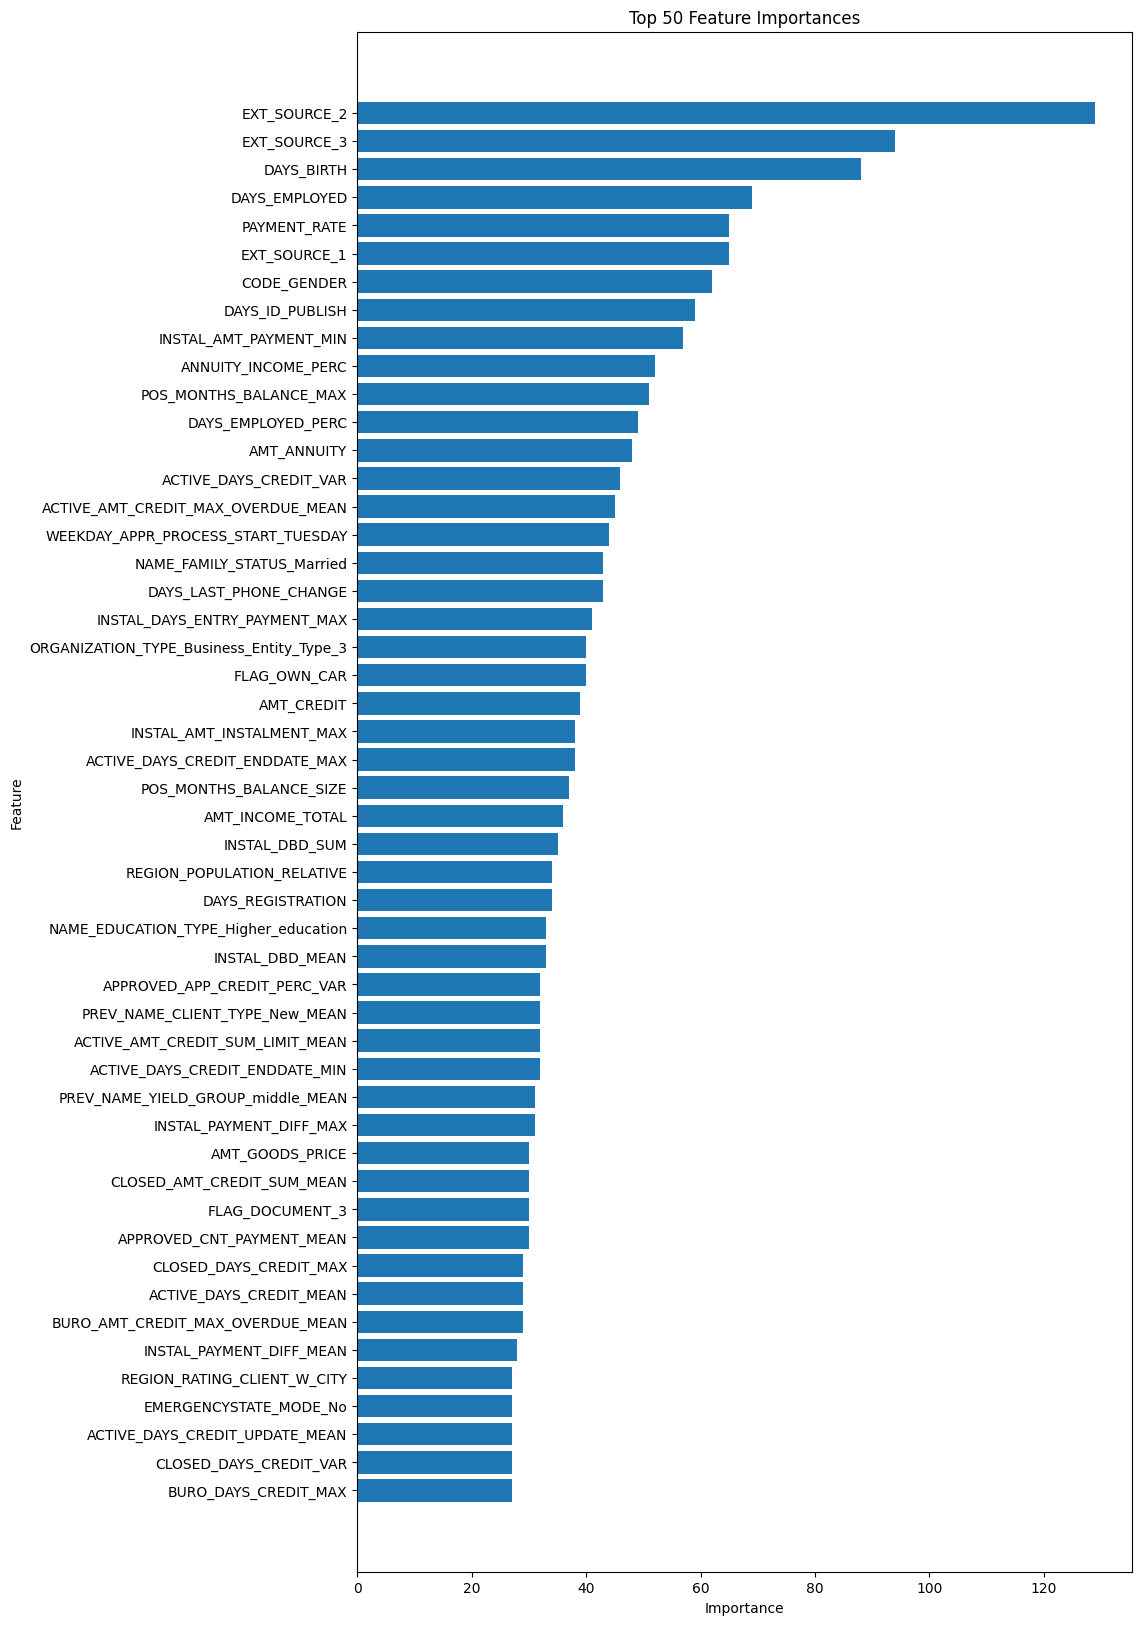

In [26]:
#la visualisation de l'importance des features

# Afficher uniquement les 50 premières features par importance
top_50_features = importance_df.head(50)

# Visualisation des 50 premières importances des features
plt.figure(figsize=(10, 20))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # Pour que les plus importantes soient en haut
plt.show()

Division initiale des données :

Les données sont divisées en 80% pour l'entraînement (X_restant, y_restant) et 20% pour les nouvelles données à prédire (X_nouveaux_clients, y_nouveaux_clients).
Enregistrement du scaler :

Le scaler (StandardScaler) est sauvegardé en tant que scaler.pkl avec joblib.dump(scaler, 'scaler.pkl') pour être utilisé dans l'API pour normaliser les futures données d'entrée.
Optimisation des hyperparamètres :

Optuna est utilisé pour optimiser les hyperparamètres avec SMOTE et validation croisée sur une petite partie des données d'entraînement initial (20%).
Entraînement final :

Une fois les meilleurs hyperparamètres trouvés via Optuna, le modèle final est entraîné sur les 80% restants des données d'entraînement (X_train_final et y_train_final) avec SMOTE appliqué pour équilibrer les classes.
Enregistrement du modèle final :

Le modèle final est enregistré en tant que model.pkl pour être utilisé dans l'API de prédiction.
Sauvegarde des résultats :

Les résultats sont sauvegardés dans un fichier CSV (results_LGM.csv), et un affichage stylisé des scores est préparé pour les visualiser.
Utilisation des fichiers model.pkl et scaler.pkl pour l'API de prédiction
Lorsque vous devrez utiliser ces fichiers pour prédire de nouvelles données via une API, vous pourrez simplement les charger avec joblib :

In [ ]:
import joblib

# Charger le modèle et le scaler
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')

# Prédiction sur de nouvelles données (exemple)
X_new_scaled = scaler.transform(X_new)
y_pred = model.predict(X_new_scaled)

Cela garantit que le même pipeline de traitement et de prédiction est utilisé pour les nouvelles données que pour les données d'entraînement.

In [30]:
# Sauvegarder X_nouveaux_clients en CSV
X_nouveaux_clients.to_csv('nouveaux_clients.csv', index=False)




In [31]:
nouveaux_clients = pd.read_csv('nouveaux_clients.csv', sep= ',')
nouveaux_clients

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,378139,1,0,1,0,85500.0,269550.0,19300.5,225000.0,0.022625,...,7765.192500,1.397735e+05,3406.09500,30119.895000,7765.192500,1.397735e+05,-108.000000,-1024.055556,-18433.000000,18.000000
1,380109,1,1,1,2,188244.0,1350000.0,34128.0,1350000.0,0.028663,...,18392.646209,6.724082e+05,5198.16081,138179.741424,18754.361918,6.785789e+05,-327.788394,-920.959958,-41719.511338,39.745552
2,384219,0,0,0,0,157500.0,254700.0,26226.0,225000.0,0.030755,...,12531.636910,1.115316e+06,102.33000,112830.480000,14285.356180,1.271397e+06,-14.000000,-637.876404,-56771.000000,89.000000
3,213755,1,0,1,0,112500.0,1293502.5,35698.5,1129500.0,0.009175,...,8680.144091,9.548159e+04,8631.13500,8685.045000,8680.144091,9.548159e+04,-371.000000,-524.363636,-5768.000000,11.000000
4,439318,1,0,1,0,207000.0,248760.0,25618.5,225000.0,0.003818,...,21808.354709,1.875519e+06,2.02500,343914.165000,21752.005291,1.870672e+06,-41.000000,-801.139535,-68898.000000,86.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,276757,0,0,1,0,103500.0,105534.0,10566.0,99000.0,0.014464,...,8100.599464,2.268168e+05,4050.67500,24862.500000,8100.599464,2.268168e+05,-399.000000,-1424.357143,-39882.000000,28.000000
1996,153845,1,0,1,0,90000.0,45000.0,4450.5,45000.0,0.026392,...,26810.020658,2.037562e+06,1420.51500,450031.725000,32731.490724,2.487593e+06,-108.000000,-1472.618421,-111919.000000,76.000000
1997,263304,1,0,0,0,193500.0,580500.0,18670.5,580500.0,0.030755,...,28440.608365,1.478912e+06,1920.06000,382500.000000,35796.377596,1.861412e+06,-45.000000,-1179.557692,-61337.000000,52.000000
1998,303064,0,0,0,0,315000.0,1125000.0,56250.0,1125000.0,0.035792,...,18392.646209,6.724082e+05,5198.16081,138179.741424,18754.361918,6.785789e+05,-327.788394,-920.959958,-41719.511338,39.745552
